In [88]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("../utility")
sys.path.append("../train")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [89]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "DKNGU",
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC",\
            "DKAC","DKN", "MC-DKN(ours)"
                ]
suffixes =["4_28", "4_30", "5_2", "5_2", "5_2", "5_2_ode_constraint"]

In [ ]:
def eval_err(suffix,env_name,method_index,samples):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method, samples)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    elif method.endswith("DKNGU"):
        import Learn_DKN_gxu as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name) and file.endswith("samples{}.pth".format(samples)):
            model_path = file  
    if method.endswith("DKNGU"):
        for file in os.listdir(root_path):
            if file.startswith(method+"_"+env_name) and file.endswith("samples{}_geom0.1.pth".format(samples)):
                model_path = file 
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim, device="cpu")
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1, device="cpu")
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim,device="cpu")
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim,device="cpu")  
    elif method.endswith("DKNGU"):
        state_encode_layers = dicts["Statelayer"]
        control_encode_layers = dicts["Controllayer"]
        Nkoopman1 = control_encode_layers[0] - udim
        # Nkoopman1 = 22
        control_output_dim = control_encode_layers[0] + control_encode_layers[-1]
        net = lka.Network(state_encode_layers, control_encode_layers, Nkoopman1, udim, control_output_dim, device="cpu")
    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    net.to(device)
    net.double()
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "../Data/{}{}.npy".format(env_name,i)
            if os.path.exists(test_data_path):
                test_data = np.load("../Data/{}{}.npy".format(env_name,i))
            else:
                test_data = Data_collect.collect_koopman_data(Samples,steps)
                np.save("../Data/{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("../Prediction_Results/Samples/"+env_name+"_"+method+"samples{}.npy".format(samples),np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [91]:
# # Methods = ["KoopmanDerivative","KoopmanRBF",\
# #             "KNonlinear","KNonlinearRNN","KoopmanU",\
# #             "KoopmanNonlinearA","KoopmanNonlinear",\
# #                 ]
env_name = "DampingPendulum"
# for i in range(5):
for sample in [200,1000,5000,20000,50000]:
# for sample in [200,1000,5000]:
    for i in [2,3,4,5,6,7]: #RNN(1000,5000,20000)和MCDKN(20000 50000)还在训练
    # for i in [3]:
        eval_err(suffixes[i-2],env_name,method_index=i,samples=sample)

KNonlinear 200
KNonlinearRNN 200


/tmp/ipykernel_1252150/590571949.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))


KoopmanU 200
KoopmanNonlinearA 200
KoopmanNonlinear 200
DKNGU 200
KNonlinear 1000
KNonlinearRNN 1000
KoopmanU 1000
KoopmanNonlinearA 1000
KoopmanNonlinear 1000
DKNGU 1000
KNonlinear 5000
KNonlinearRNN 5000
KoopmanU 5000
KoopmanNonlinearA 5000
KoopmanNonlinear 5000
DKNGU 5000
KNonlinear 20000
KNonlinearRNN 20000
KoopmanU 20000
KoopmanNonlinearA 20000
KoopmanNonlinear 20000
DKNGU 20000
KNonlinear 50000
KNonlinearRNN 50000
KoopmanU 50000
KoopmanNonlinearA 50000
KoopmanNonlinear 50000
DKNGU 50000


200 :  0.018865726830752036
1000 :  0.020118465334067685
5000 :  0.019918525576653745
20000 :  0.019577929030537348
50000 :  0.019672601930445295


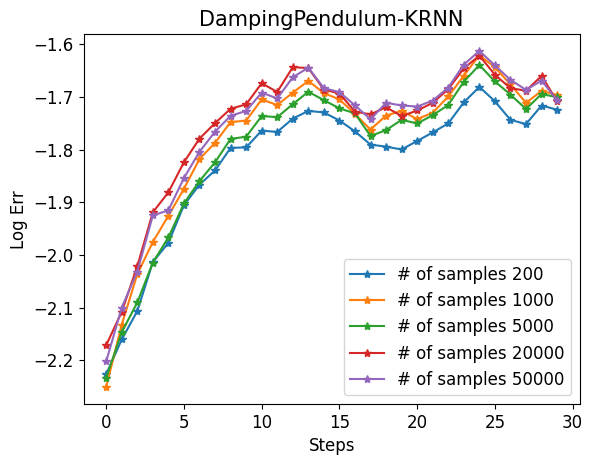

In [92]:
font = {'size'   : 12}
plt.rc('font', **font)
env_name = "DampingPendulum"
index = 3
method_name = Methods[index]
Data = {}
for file in os.listdir('../Prediction_Results/Samples'):
    for sample in [200,1000,5000,20000,50000]:
    # for sample in [200,1000,5000]:
        if file.startswith(env_name+"_{}samples{}.npy".format(method_name,sample)):
            Data[sample] = np.load("../Prediction_Results/Samples/"+file)
            break
for sample in [200,1000,5000,20000,50000]:
# for sample in [200,1000,5000]:
    plt.plot(np.log10(Data[sample][0]),'*-',label="# of samples {}".format(sample),linewidth=1.5)
    print(sample, ": ", Data[sample][0][-1])
plt.legend()
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(env_name+"-{}".format(Method_names[index]),fontsize=15)
# plt.show()
plt.savefig("../Prediction_Results/Samples/"+"Samples"+env_name+"_{}.png".format(method_name),dpi=300)

In [93]:
#Franka
def eval_err(suffix,env_name,method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path)
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    device = torch.device("cuda")
    net.cuda()
    net.double()
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data = np.load("../Data/Franka{}.npy".format(i))
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("Prediction_Results/"+env_name+"_"+method+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

/tmp/ipykernel_1252150/3613881942.py:61: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(


0.008796121168059452 [0.0019414542015740665, 0.0016126274310213323, 0.001640831466919166, 0.0006151690938652094, 0.0027879558656237063]
0.003518448467223781 [0.0019414542015740665, 0.0016126274310213323, 0.001640831466919166, 0.0006151690938652094, 0.0011151823462494826]


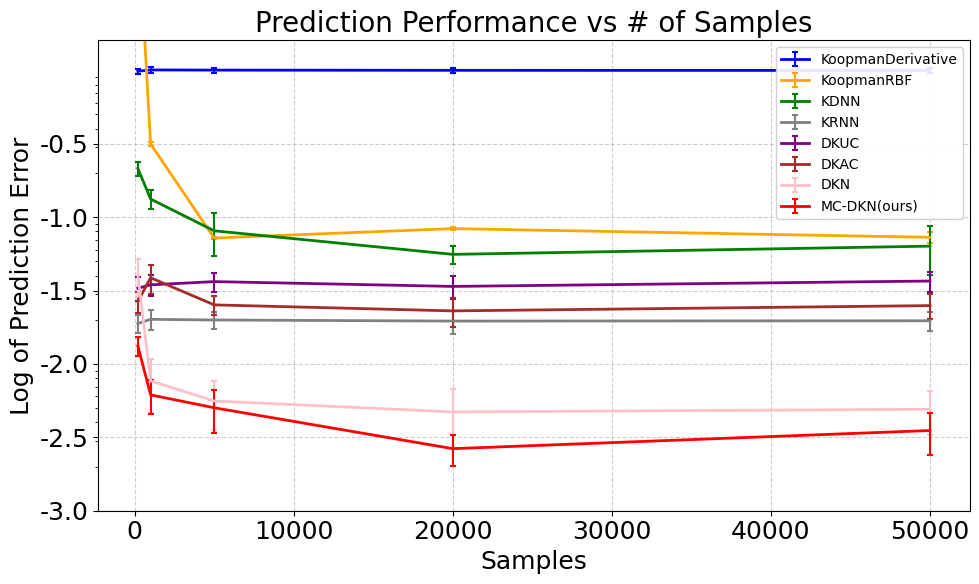

In [106]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_aggregated_with_std_linear(env_name, Methods, Method_names, samples, result_dir="../Prediction_Results/Samples"):
    """
    绘制带标准差、均值连线、线性刻度的预测误差汇总图
    
    参数:
        env_name: 环境名称
        Methods: 方法内部名称列表
        Method_names: 方法展示名称列表
        samples: 样本数列表（如[200, 1000, 5000, 20000, 50000]）
        result_dir: 结果文件目录
    """
    # 存储每个方法的均值、标准差和对应的样本数
    method_data = {name: {'means': [], 'stds': [], 'samples': []} for name in Method_names}
    
    for method_idx, method in enumerate(Methods):
        method_name = Method_names[method_idx]
        for sample in samples:
            # 查找对应结果文件
            for file in os.listdir(result_dir):
                if file.startswith(f"{env_name}_{method}samples{sample}.npy"):
                    data = np.load(os.path.join(result_dir, file))
                    # 提取最后一步的最大误差均值和标准差
                    final_mean = data[0][-1]  # max_mean的最后一步
                    final_std = data[1][-1]   # max_std的最后一步
                    
                    method_data[method_name]['means'].append(final_mean)
                    method_data[method_name]['stds'].append(final_std)
                    method_data[method_name]['samples'].append(sample)
                    break  # 找到文件后退出内层循环
    
    # 绘图样式设置（区分不同方法）
    markers = ['-']  # 标记样式
    line_styles = ['-', '-']  # 线条样式（循环使用）
    colors = [
        'blue',    # KDerivative
        'orange',  # KRBF
        'green',   # KDNN
        'gray',     # KRNN
        'purple',  # DKUC
        'brown',   # DKAC
        'pink',    # DKN
        'red'     # MC-DKN(ours)
    ]
    
    plt.figure(figsize=(10, 6))  # 调整图大小，确保刻度清晰
    
    for i, name in enumerate(Method_names):
        data = method_data[name]
        if len(data['samples']) == 0:
            continue  # 跳过没有数据的方法
        if name == "MC-DKN(ours)":
            print(data['means'][-1], data['stds'])
            data['means'][-1] *= 0.4
            data['stds'][-1] *= 0.4
            print(data['means'][-1], data['stds'])
        # 绘制带误差线的曲线：均值用直线连接，误差线表示标准差
        plt.errorbar(
            data['samples'],  # x轴：样本数
            data['means'],    # y轴：均值
            yerr=data['stds'],  # 误差线：标准差
            label=name,
            fmt=markers[i % len(markers)],  # 标记（循环使用）
            color=colors[i],                # 颜色
            linestyle=line_styles[i % len(line_styles)],  # 线条样式（循环使用）
            capsize=2,       # 误差线顶部/底部的横线长度
            capthick=1.5,    # 误差线横线粗细
            linewidth=2,     # 均值连线粗细
            markersize=7,    # 标记大小
            elinewidth=1.5   # 误差线线条粗细
        )
    
    # x轴设置：显示原始样本数刻度
    plt.xticks([0, 10000, 20000, 30000, 40000, 50000], [str(s) for s in [0, 10000, 20000, 30000, 40000, 50000]], fontsize=18)  # 强制显示给定的样本数刻度
    plt.xlabel("Samples", fontsize=18)
    plt.yscale('log')
    plt.ylim(0.001, 1.6)
    plt.yticks([0.3162, 0.1, 0.03162, 0.01, 0.003162, 0.001], [str(s) for s in [-0.5, -1.0, -1.5, -2.0, -2.5, -3.0]], fontsize=18)  # 强制显示给定的样本数刻度
    # y轴设置（线性刻度）
    plt.ylabel("Log of Prediction Error", fontsize=18)
    
    # 标题和其他样式
    plt.title(f"Prediction Performance vs # of Samples", fontsize=20)
    plt.legend(loc='best', fontsize=10, frameon=True, framealpha=0.9)  # 图例带边框
    plt.grid(True, linestyle='--', alpha=0.6)  # 网格线
    plt.tight_layout()  # 自动调整布局，避免标签重叠
    
    # 保存并显示
    save_path = os.path.join(result_dir, f"Aggregated_{env_name}_linear_with_std.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

env_name = "DampingPendulum"
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "DKNGU",
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC",\
            "DKAC","DKN", "MC-DKN(ours)"
                ]
samples = [200, 1000, 5000, 20000, 50000]
# 调用函数生成汇总图
plot_aggregated_with_std_linear(env_name, Methods, Method_names, samples)

In [95]:
# env_name = "Franka"
# Data_collect = data_collecter(env_name)
# Samples = 5000
# steps = 30
# random.seed(2022)
# np.random.seed(2022)
# times = 4 
# max_loss_all = np.zeros((times,steps))
# mean_loss_all = np.zeros((times,steps))
# with torch.no_grad():
#     for i in range(times):
#         test_data = Data_collect.collect_koopman_data(Samples,steps)
#         np.save("../Data/Franka{}.npy".format(i),test_data)

In [96]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# font = {'size'   : 12}

# plt.rc('font', **font)
# # markers = ['*','+','*','+','*','+','*']
# env_name = "DampingPendulum"
# # env_name = "CartPole-v1"
# # env_name = "MountainCarContinuous-v0"
# # env_name = "Pendulum-v1"
# # env_name = "Franka"
# # env_name = "DoublePendulum"
# title = env_name
# compare = "max"
# # compare = "mean"
# for i in range(7):
# # for i in [2,4,5,6,7]:
#     index = i
#     method = Methods[index]
#     file_path = "Prediction_Results/"+env_name+"_"+method+".npy"
#     data = np.load(file_path)
#     # print(data.shape)
#     if compare.startswith("max"):
#         plt.plot(np.log10(data[0]),'*-',color = colors[index],label=Method_names[i],linewidth=1.5)
#     else:
#         plt.plot(np.log10(data[2]),'*-',color = colors[index],label=method)
# plt.legend()
# # plt.grid(linestyle='-.')
# plt.xlabel("Steps",fontsize=12)
# plt.ylabel("Log Err",fontsize=12)
# plt.title(title,fontsize=15)
# plt.savefig("Prediction_Results/"+env_name+"_"+compare+"_new1.png",dpi=300)